## Discretized SARSA for mountain-car problem

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math
import random
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

### Step 2: Class Mountain car: 

Defines the environment consisting of a hill .Then provide bounds for the maximum and minimum velocity and position. Next, define the action space. 

Once the environment is setup, we will discretise the continuous state and compute the value for each state-action pair possible. Further, actions are taken according to the epsilon-greedy algorithm. 

In [2]:
class MountainCar(object):
    def __init__(self,alpha=0.3,gamma=1.0,epsilon=0.01):
        super(MountainCar, self).__init__()          
        self.alpha       = alpha    #learning rate
        self.gamma       = gamma    #discount factor
        self.epsilon     = epsilon  #probability of a random action selection
        self.statelist   = self.BuildSateList()     # the list of states
        self.actionlist  = self.BuildActionList()   # the list of actions        
        self.nactions    = self.actionlist.shape[0] # number of actions
        self.Q           = self.BuildQTable()       # the Qtable

    def BuildSateList(self):
        # state discretization for the mountain car problem
        xdiv  = (0.55-(-1.5))   / 10.0
        xpdiv = (0.07-(-0.07)) / 5.0
        
        x = np.arange(-1.5,0.5+xdiv,xdiv)
        xp= np.arange(-0.07,0.07+xpdiv,xpdiv)

        N=x.size
        M=xp.size

        states=[] #zeros((N*M,2)).astype(Float32)
        #index=0
        for i in range(N):    
            for j in range(M):
                states.append([x[i], xp[j]])        
        return np.array(states)

    def BuildActionList(self):
        return np.array([-1.0 , 0.0 , 1.0])

    def BuildQTable(self):
        nstates     = self.statelist.shape[0]
        nactions    = self.actionlist.shape[0]
        Q = [[0.0 for i in range(nactions)] for i in range(nstates)]
        return Q

    def GetReward(self, x ):
        # MountainCarGetReward returns the reward at the current state
        # x: a vector of position and velocity of the car
        # r: the returned reward.
        # f: true if the car reached the goal, otherwise f is false
            
        position = x[0]
        # bound for position; the goal is to reach position = 0.45
        bpright  = 0.45

        r = -1
        f = False
        
        
        if  position >= bpright:
            r = 100
            f = True
        
        return r,f

    
    def DoAction(self, force, x ):
        #MountainCarDoAction: executes the action (a) into the mountain car
        # a: is the force to be applied to the car
        # x: is the vector containning the position and speed of the car
        # xp: is the vector containing the new position and velocity of the car

        position = x[0]
        speed    = x[1] 

        # bounds for position
        bpleft=-1.5 

        # bounds for speed
        bsleft=-0.07 
        bsright=0.07
         
        speedt1= speed + (0.001*force) + (-0.0025 * math.cos( 3.0*position) )	 
        speedt1= speedt1 * 0.999 # thermodynamic law, for a more real system with friction.

        if speedt1<bsleft: 
            speedt1=bsleft 
        elif speedt1>bsright:
            speedt1=bsright    

        post1 = position + speedt1 

        if post1<=bpleft:
            post1=bpleft
            speedt1=0.0
            
        xp = np.array([post1,speedt1])
        return xp


    def GetInitialState(self):
        initial_position = -0.5
        initial_speed    =  0.0    
        return  np.array([initial_position,initial_speed])

    def DiscretizeState(self,x):    
        """DiscretizeState check which entry in the state list is more close to x and return the index of that entry."""
        
        edist2   = np.sqrt(np.sum((self.statelist-x)**2,1))
        return     np.argmin(edist2) 

    def e_greedy_selection(self, s):
        #selects an action using Epsilon-greedy strategy
        # Q: the Qtable
        # s: the current state        
                
        if (random.random()>self.epsilon):
            a = self.GetBestAction(s)    
        else:
            # selects a random action based on a uniform distribution
            a = random.randint(0, 2)
            #print(a)
        return a
        
    def GetBestAction(self, s ):
        #GetBestAction return the best action for state (s)
        #Q: the Qtable
        #the current state
        #has structure  Q(states,actions)
        
        #a = argmax(self.Q[s,:].flat)
        a  = np.argmax(self.Q[s])    
        return a

    def UpdateSARSA(self, s, a, r, sp, ap):
        """ Update Qtable using SARSA"""
        #print (s,sp, self.Q)
        self.Q[s][a]  = self.Q[s][a] + self.alpha * ( r + self.gamma*self.Q[sp][ap] - self.Q[s][a] )

    def SARSAEpisode(self, maxsteps=100, grafic = False):
        # do one episode with sarsa learning
        # maxstepts: the maximum number of steps per episode
        # Q: the current QTable
        # alpha: the current learning rate
        # gamma: the current discount factor
        # epsilon: probablity of a random action
        # statelist: the list of states
        # actionlist: the list of actions
        x_points = []
        y_points=[]
        x                = self.GetInitialState()
        steps            = 0
        total_reward     = 0
        x_points.append(x)

        # convert the continous state variables to an index of the statelist
        s   = self.DiscretizeState(x)
        
        # selects an action using the epsilon greedy selection strategy
        a   = self.e_greedy_selection(s)
        Cost = -np.max(self.Q[s])
        y_points.append(Cost)

        for i in range(1,maxsteps+1):
                        
            # convert the index of the action into an action value
            action = self.actionlist[a]    
            
            # do the selected action and get the next car state    
            xp     = self.DoAction( action , x )    
            
            # observe the reward at state xp and the final state flag
            r,isfinal    = self.GetReward(xp)
            total_reward = total_reward + r
            
            # convert the continous state variables in [xp] to an index of the statelist
            sp     = self.DiscretizeState(xp)
            
            # select action prime
            ap     = self.e_greedy_selection(sp)
            #print(ap)
            
            # Update the Qtable, that is,  learn from the experience
            self.UpdateSARSA( s, a, r, sp, ap)
            
            Cost = -np.max(self.Q[sp])
            y_points.append(Cost)
            x_points.append(xp)
            #update the current variables
            s = sp
            a = ap
            x = xp
            
            #if graphic function then show graphics
            if grafic:
                self.PlotFunc(x,a,steps)
                
            
            #increment the step counter.
            steps = steps+1
            
            # if reachs the goal breaks the episode
            if isfinal==True:
                break
        
        return total_reward,steps, x_points, y_points

### Step-3: 
Run the Code for 200 episodes. Each episode has maximum steps of 1000.

In [3]:
def MountainCarDemo(maxepisodes):
    MC  = MountainCar()
    maxsteps = 1000
    grafica  = False
    
    for i in range(1, maxepisodes+1):    
        X, Y =[], []
        total_reward,steps, x, Z  = MC.SARSAEpisode( maxsteps, grafica )    
        for j in range(len(x)):
            X.append(x[j][0]) 
            Y.append(x[j][1]) 
        
        if i==1000:
            fig = plt.figure()
            ax = fig.gca(projection='3d')          
            surf = ax.plot_trisurf(X, Y, Z, cmap=plt.cm.viridis, linewidth=0.2)
            fig.colorbar( surf, shrink=0.5, aspect=10)
            plt.xlabel("position")
            plt.ylabel("velocity")
            plt.zlabel("Cost function")
            plt.show()

        print ('Espisode: ',i,'  Steps:',steps,'  Reward:',str(total_reward),' epsilon: ',str(MC.epsilon))
        
        MC.epsilon = MC.epsilon * 0.99


Espisode:  1   Steps: 1000   Reward: -1000  epsilon:  0.01
Espisode:  2   Steps: 974   Reward: -873  epsilon:  0.0099
Espisode:  3   Steps: 424   Reward: -323  epsilon:  0.009801
Espisode:  4   Steps: 690   Reward: -589  epsilon:  0.00970299
Espisode:  5   Steps: 1000   Reward: -1000  epsilon:  0.0096059601
Espisode:  6   Steps: 831   Reward: -730  epsilon:  0.009509900499
Espisode:  7   Steps: 1000   Reward: -1000  epsilon:  0.00941480149401
Espisode:  8   Steps: 1000   Reward: -1000  epsilon:  0.0093206534790699
Espisode:  9   Steps: 1000   Reward: -1000  epsilon:  0.0092274469442792
Espisode:  10   Steps: 719   Reward: -618  epsilon:  0.009135172474836408
Espisode:  11   Steps: 409   Reward: -308  epsilon:  0.009043820750088045
Espisode:  12   Steps: 301   Reward: -200  epsilon:  0.008953382542587164
Espisode:  13   Steps: 333   Reward: -232  epsilon:  0.008863848717161293
Espisode:  14   Steps: 296   Reward: -195  epsilon:  0.00877521022998968
Espisode:  15   Steps: 244   Reward: -

Espisode:  143   Steps: 163   Reward: -62  epsilon:  0.002399924795841344
Espisode:  144   Steps: 163   Reward: -62  epsilon:  0.0023759255478829305
Espisode:  145   Steps: 163   Reward: -62  epsilon:  0.002352166292404101
Espisode:  146   Steps: 159   Reward: -58  epsilon:  0.00232864462948006
Espisode:  147   Steps: 163   Reward: -62  epsilon:  0.0023053581831852595
Espisode:  148   Steps: 163   Reward: -62  epsilon:  0.002282304601353407
Espisode:  149   Steps: 163   Reward: -62  epsilon:  0.002259481555339873
Espisode:  150   Steps: 163   Reward: -62  epsilon:  0.0022368867397864743
Espisode:  151   Steps: 163   Reward: -62  epsilon:  0.0022145178723886093
Espisode:  152   Steps: 163   Reward: -62  epsilon:  0.002192372693664723
Espisode:  153   Steps: 163   Reward: -62  epsilon:  0.002170448966728076
Espisode:  154   Steps: 163   Reward: -62  epsilon:  0.002148744477060795
Espisode:  155   Steps: 163   Reward: -62  epsilon:  0.002127257032290187
Espisode:  156   Steps: 163   Rewar

Espisode:  255   Steps: 163   Reward: -62  epsilon:  0.0007786448720191188
Espisode:  256   Steps: 163   Reward: -62  epsilon:  0.0007708584232989276
Espisode:  257   Steps: 163   Reward: -62  epsilon:  0.0007631498390659383
Espisode:  258   Steps: 163   Reward: -62  epsilon:  0.000755518340675279
Espisode:  259   Steps: 163   Reward: -62  epsilon:  0.0007479631572685261
Espisode:  260   Steps: 163   Reward: -62  epsilon:  0.0007404835256958409
Espisode:  261   Steps: 163   Reward: -62  epsilon:  0.0007330786904388825
Espisode:  262   Steps: 163   Reward: -62  epsilon:  0.0007257479035344936
Espisode:  263   Steps: 163   Reward: -62  epsilon:  0.0007184904244991487
Espisode:  264   Steps: 163   Reward: -62  epsilon:  0.0007113055202541572
Espisode:  265   Steps: 163   Reward: -62  epsilon:  0.0007041924650516157
Espisode:  266   Steps: 163   Reward: -62  epsilon:  0.0006971505404010995
Espisode:  267   Steps: 166   Reward: -65  epsilon:  0.0006901790349970885
Espisode:  268   Steps: 16

Espisode:  371   Steps: 163   Reward: -62  epsilon:  0.00024267330287830794
Espisode:  372   Steps: 163   Reward: -62  epsilon:  0.00024024656984952486
Espisode:  373   Steps: 163   Reward: -62  epsilon:  0.00023784410415102962
Espisode:  374   Steps: 163   Reward: -62  epsilon:  0.00023546566310951933
Espisode:  375   Steps: 163   Reward: -62  epsilon:  0.00023311100647842415
Espisode:  376   Steps: 163   Reward: -62  epsilon:  0.0002307798964136399
Espisode:  377   Steps: 163   Reward: -62  epsilon:  0.0002284720974495035
Espisode:  378   Steps: 163   Reward: -62  epsilon:  0.00022618737647500848
Espisode:  379   Steps: 163   Reward: -62  epsilon:  0.00022392550271025838
Espisode:  380   Steps: 163   Reward: -62  epsilon:  0.0002216862476831558
Espisode:  381   Steps: 163   Reward: -62  epsilon:  0.00021946938520632424
Espisode:  382   Steps: 163   Reward: -62  epsilon:  0.000217274691354261
Espisode:  383   Steps: 163   Reward: -62  epsilon:  0.00021510194444071838
Espisode:  384   

Espisode:  493   Steps: 163   Reward: -62  epsilon:  7.120586097206619e-05
Espisode:  494   Steps: 163   Reward: -62  epsilon:  7.049380236234553e-05
Espisode:  495   Steps: 163   Reward: -62  epsilon:  6.978886433872207e-05
Espisode:  496   Steps: 163   Reward: -62  epsilon:  6.909097569533485e-05
Espisode:  497   Steps: 163   Reward: -62  epsilon:  6.84000659383815e-05
Espisode:  498   Steps: 163   Reward: -62  epsilon:  6.771606527899769e-05
Espisode:  499   Steps: 163   Reward: -62  epsilon:  6.703890462620771e-05
Espisode:  500   Steps: 163   Reward: -62  epsilon:  6.636851557994564e-05
Espisode:  501   Steps: 163   Reward: -62  epsilon:  6.570483042414618e-05
Espisode:  502   Steps: 163   Reward: -62  epsilon:  6.504778211990472e-05
Espisode:  503   Steps: 163   Reward: -62  epsilon:  6.439730429870567e-05
Espisode:  504   Steps: 163   Reward: -62  epsilon:  6.375333125571861e-05
Espisode:  505   Steps: 163   Reward: -62  epsilon:  6.311579794316142e-05
Espisode:  506   Steps: 16

Espisode:  639   Steps: 163   Reward: -62  epsilon:  1.6415501428270468e-05
Espisode:  640   Steps: 163   Reward: -62  epsilon:  1.6251346413987764e-05
Espisode:  641   Steps: 163   Reward: -62  epsilon:  1.6088832949847885e-05
Espisode:  642   Steps: 163   Reward: -62  epsilon:  1.5927944620349405e-05
Espisode:  643   Steps: 163   Reward: -62  epsilon:  1.576866517414591e-05
Espisode:  644   Steps: 163   Reward: -62  epsilon:  1.561097852240445e-05
Espisode:  645   Steps: 163   Reward: -62  epsilon:  1.5454868737180407e-05
Espisode:  646   Steps: 163   Reward: -62  epsilon:  1.53003200498086e-05
Espisode:  647   Steps: 163   Reward: -62  epsilon:  1.5147316849310516e-05
Espisode:  648   Steps: 163   Reward: -62  epsilon:  1.4995843680817411e-05
Espisode:  649   Steps: 163   Reward: -62  epsilon:  1.4845885244009237e-05
Espisode:  650   Steps: 163   Reward: -62  epsilon:  1.4697426391569144e-05
Espisode:  651   Steps: 163   Reward: -62  epsilon:  1.4550452127653453e-05
Espisode:  652  

Espisode:  751   Steps: 163   Reward: -62  epsilon:  5.325936058869034e-06
Espisode:  752   Steps: 163   Reward: -62  epsilon:  5.272676698280344e-06
Espisode:  753   Steps: 163   Reward: -62  epsilon:  5.21994993129754e-06
Espisode:  754   Steps: 163   Reward: -62  epsilon:  5.167750431984565e-06
Espisode:  755   Steps: 163   Reward: -62  epsilon:  5.116072927664719e-06
Espisode:  756   Steps: 163   Reward: -62  epsilon:  5.0649121983880715e-06
Espisode:  757   Steps: 163   Reward: -62  epsilon:  5.0142630764041905e-06
Espisode:  758   Steps: 163   Reward: -62  epsilon:  4.9641204456401485e-06
Espisode:  759   Steps: 163   Reward: -62  epsilon:  4.914479241183747e-06
Espisode:  760   Steps: 163   Reward: -62  epsilon:  4.86533444877191e-06
Espisode:  761   Steps: 163   Reward: -62  epsilon:  4.816681104284191e-06
Espisode:  762   Steps: 163   Reward: -62  epsilon:  4.768514293241349e-06
Espisode:  763   Steps: 163   Reward: -62  epsilon:  4.720829150308935e-06
Espisode:  764   Steps: 

Espisode:  866   Steps: 163   Reward: -62  epsilon:  1.6766535271071777e-06
Espisode:  867   Steps: 163   Reward: -62  epsilon:  1.659886991836106e-06
Espisode:  868   Steps: 163   Reward: -62  epsilon:  1.6432881219177447e-06
Espisode:  869   Steps: 163   Reward: -62  epsilon:  1.6268552406985672e-06
Espisode:  870   Steps: 163   Reward: -62  epsilon:  1.6105866882915816e-06
Espisode:  871   Steps: 163   Reward: -62  epsilon:  1.5944808214086658e-06
Espisode:  872   Steps: 163   Reward: -62  epsilon:  1.578536013194579e-06
Espisode:  873   Steps: 163   Reward: -62  epsilon:  1.5627506530626331e-06
Espisode:  874   Steps: 163   Reward: -62  epsilon:  1.5471231465320069e-06
Espisode:  875   Steps: 163   Reward: -62  epsilon:  1.5316519150666867e-06
Espisode:  876   Steps: 163   Reward: -62  epsilon:  1.51633539591602e-06
Espisode:  877   Steps: 163   Reward: -62  epsilon:  1.5011720419568597e-06
Espisode:  878   Steps: 163   Reward: -62  epsilon:  1.486160321537291e-06
Espisode:  879   

Espisode:  993   Steps: 163   Reward: -62  epsilon:  4.6785690203749216e-07
Espisode:  994   Steps: 163   Reward: -62  epsilon:  4.6317833301711725e-07
Espisode:  995   Steps: 163   Reward: -62  epsilon:  4.5854654968694606e-07
Espisode:  996   Steps: 163   Reward: -62  epsilon:  4.539610841900766e-07
Espisode:  997   Steps: 163   Reward: -62  epsilon:  4.4942147334817586e-07
Espisode:  998   Steps: 163   Reward: -62  epsilon:  4.449272586146941e-07
Espisode:  999   Steps: 163   Reward: -62  epsilon:  4.4047798602854717e-07


AttributeError: module 'matplotlib.pyplot' has no attribute 'zlabel'

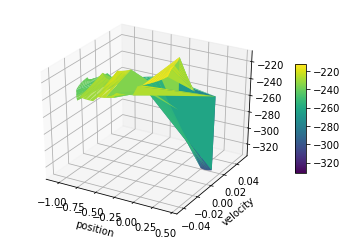

In [4]:
if __name__ == '__main__':
    MountainCarDemo(1000) 